### Ideas tried:
    + square & cube of features high correlated with y
    + lasso for feature selection
    + one hot encoding 
    + fill na with means
    + taking log of features where skewness > 0.75
    - turning numerical features that seem categorical into categorical
    - standarization 
    - dropping some of the highly correlated features
    - removing features with low variance
    

### Algorithms:
    + Gradient Boosting Regressor (BEST)
    + Lasso
    + Ridge
    + Random Forest Regressor
    - Stochastic Gradient Descent Regressor
    - Support Vector Regressor

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import skew
%matplotlib inline

from __future__ import division

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
dataset = pd.read_csv("train.csv") 
simple_dataset = dataset.copy()

In [4]:
def get_1h_cols(data_means):
    one_hot_dict = {}
    for col in list(data_means):
        unique_vals = np.array( pd.Series(data_means[col].unique()).dropna() )
        if(isinstance(unique_vals[0], str)):
            one_hot_dict[col] = unique_vals
    return one_hot_dict

def one_hot_encode(data, one_hot_cols):
    for col, vals in one_hot_cols.iteritems():
        for unique_val in vals:
            data.loc[:, col + '_' + unique_val] = data[col].isin([unique_val])
        data = data.drop(col, axis=1)
    return data

def get_polynomials(data, features, power):
    for col in features:
        data.loc[:, col + '_squared'] = data[col].apply(lambda x: x**power)
    return data

def num_to_cat(data, features):
    for feature in features:
        data.loc[:, feature] = data[feature].apply(lambda x: str(x))
    return data

### Explore data

In [5]:
col_notes = {
    'Id': 'prob useless',
    'MSSubClass': 'rather categ',
    'MoSold': 'rather categ',
    'Street': '2 categories',
    'CentralAir': '2 categories',
    'FireplaceQu': 'high NA %',
    'SalePrice': 'label'
}

na_meaning = {
    'Alley': 'no_allay',
    'PoolQC': 'no_pool',
    'Fence': 'no_fence',
    'MiscFeature': 'no_features',
    'BsmtQual': 'no_bsmnt',
    'BsmtCond': 'no_bsmnt',
    'BsmtCond': 'no_bsmnt',
    'BsmtExposure': 'no_bsmnt',
    'BsmtFinType1': 'no_bsmnt',
    'BsmtFinType2': 'no_bsmnt',
    'GarageType': 'no_garage',
    'GarageFinish': 'no_garage',
    'GarageQual': 'no_garage',
    'GarageCond': 'no_garage',
    'MasVnrType': 'no_masonry',
    'FireplaceQu': 'no_fireplace',
    'Electrical': 'no_data'
}


d = {'NAME': [], 
     'EX_1': [], 
     'EX_2': [], 
     'NULLS': [], 
     'TYPE': [],
     'UNIQUE': [],
     'NOTES': [],
     'NA meaning': []}

dataset_len = len(simple_dataset)

for col in list(simple_dataset):    
    unique_val_1 = np.array(pd.Series(dataset[col].unique()).dropna())[0]
    unique_val_2 = np.array(pd.Series(dataset[col].unique()).dropna())[1]
  
    tp = 'string' if (isinstance(unique_val_1, str)) else 'number'
    nulls = simple_dataset[col].isnull().sum() / dataset_len
    nulls = str(nulls*100)[:4] + '%'
    note = col_notes[col] if col in col_notes else '---'
    na_m = na_meaning[col] if col in na_meaning else '---'
    
    d['NAME']      = d['NAME']      + [col]
    d['EX_1']      = d['EX_1']      + [unique_val_1]
    d['EX_2']      = d['EX_2']      + [unique_val_2]
    d['NULLS']     = d['NULLS']     + [nulls]
    d['TYPE']      = d['TYPE']      + [tp]
    d['UNIQUE']    = d['UNIQUE']    + [len(dataset[col].unique())]
    d['NOTES']     = d['NOTES']     + [note]
    d['NA meaning']= d['NA meaning']+ [na_m]
    
with pd.option_context('display.max_rows', len(d['NAME']), 'expand_frame_repr', False):
    print pd.DataFrame(d)[['NAME', 'TYPE', 'EX_1', 'EX_2', 'UNIQUE', 'NULLS', 'NA meaning', 'NOTES']]

             NAME    TYPE     EX_1     EX_2  UNIQUE  NULLS    NA meaning         NOTES
0              Id  number        1        2    1460   0.0%           ---  prob useless
1      MSSubClass  number       60       20      15   0.0%           ---  rather categ
2        MSZoning  string       RL       RM       5   0.0%           ---           ---
3     LotFrontage  number       65       80     111  17.7%           ---           ---
4         LotArea  number     8450     9600    1073   0.0%           ---           ---
5          Street  string     Pave     Grvl       2   0.0%           ---  2 categories
6           Alley  string     Grvl     Pave       3  93.7%      no_allay           ---
7        LotShape  string      Reg      IR1       4   0.0%           ---           ---
8     LandContour  string      Lvl      Bnk       4   0.0%           ---           ---
9       Utilities  string   AllPub   NoSeWa       2   0.0%           ---           ---
10      LotConfig  string   Inside      FR2

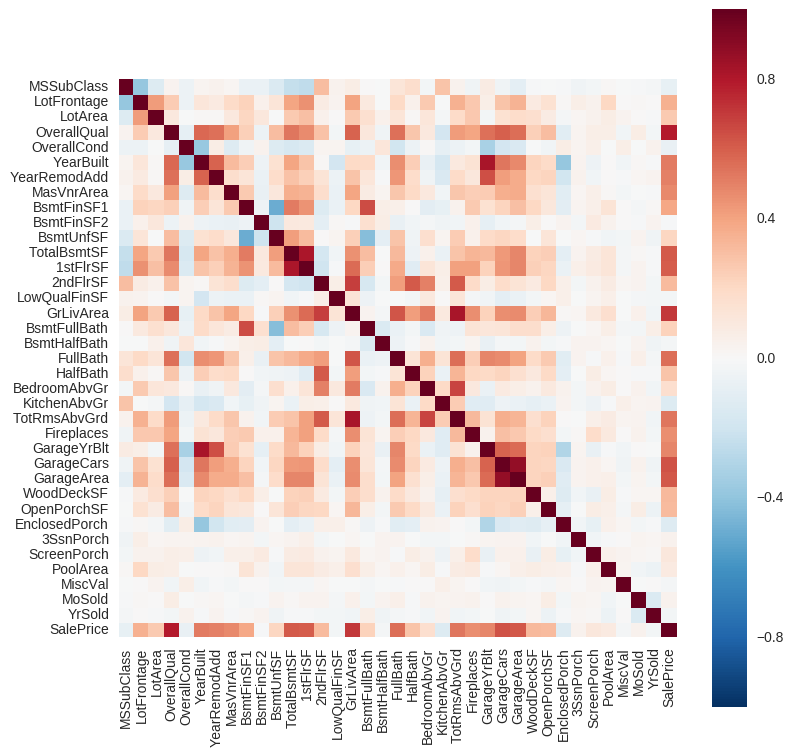

In [6]:
num_cols = simple_dataset.select_dtypes(include = ['float64', 'int64'])
corr = num_cols.drop('Id', axis=1).corr()

plt.figure(figsize=(9,9))
sns.heatmap(corr, vmax=1, square=True)

In [7]:
print 'large to Moderate correlations with y:'
print
label_corr = np.abs(corr['SalePrice'])
label_corr = label_corr[label_corr > 0.3]
label_corr = label_corr.sort_values(ascending=False)[1:]
print label_corr

large to Moderate correlations with y:

OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
BsmtFinSF1      0.386420
LotFrontage     0.351799
WoodDeckSF      0.324413
2ndFlrSF        0.319334
OpenPorchSF     0.315856
Name: SalePrice, dtype: float64


In [8]:
large_label_corr = label_corr[label_corr > 0.5]
large_corr_feats = np.array(large_label_corr.index)

### DEMO: Skewness

no_skew -> 0.0
pos_skew -> 0.914812829571


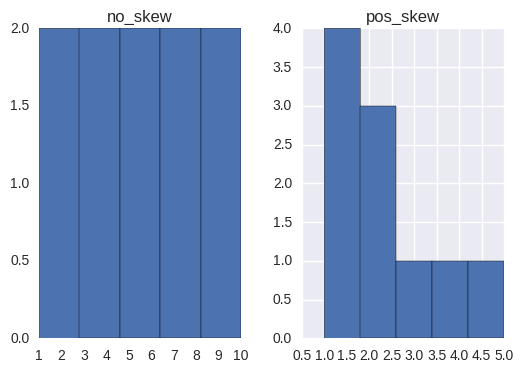

In [9]:
no_skew  = [1,2,3,4,5,6,7,8,9,10]
pos_skew = [1,1,1,1,2,2,2,3,4,5]

skew_data = pd.DataFrame({'no_skew': no_skew, 'pos_skew': pos_skew})
skew_data.hist(bins=5)

print 'no_skew ->', skew(no_skew)
print 'pos_skew ->', skew(pos_skew)

In [10]:
simple_dataset = simple_dataset.drop('SalePrice', axis=1)

### numerical -> categorical

In [11]:
#simple_dataset = num_to_cat(simple_dataset, ['MSSubClass', 'MoSold'])

### log of features

In [12]:
numeric_col_idx = simple_dataset.dtypes[simple_dataset.dtypes != "object"].index
col_skewness = simple_dataset[numeric_col_idx].apply(lambda col: skew(col.dropna()))

skewed_col_idx = col_skewness[col_skewness > 0.75].index
simple_dataset[skewed_col_idx] = np.log1p(simple_dataset[skewed_col_idx])

In [13]:
simple_dataset['SalePrice'] = np.log1p(dataset.loc[:, 'SalePrice'])

In [14]:
print simple_dataset['SalePrice'][:3] # log(predictions)
print dataset['SalePrice'][:3]

0    12.247699
1    12.109016
2    12.317171
Name: SalePrice, dtype: float64
0    208500
1    181500
2    223500
Name: SalePrice, dtype: int64


### split  +  one hot + fill na + poly important features

In [15]:
from sklearn.preprocessing import StandardScaler
stdScal = StandardScaler()

In [16]:
train_s = simple_dataset[:1100]
train_s = train_s.drop('Id', axis=1)

one_hot_cols = get_1h_cols(train_s)
train_s = one_hot_encode(train_s, one_hot_cols)
train_s = train_s.fillna(train_s.mean())
train_s = get_polynomials(train_s, large_corr_feats, 2)
train_s = get_polynomials(train_s, large_corr_feats, 3)

train_s_x = train_s.drop('SalePrice', axis=1)
#numerical_features = train_s_x.select_dtypes(exclude = ["object"]).columns
#train_s_x.loc[:, numerical_features] = stdScal.fit_transform(train_s_x.loc[:, numerical_features])
train_s_y = train_s.loc[:, 'SalePrice']

In [17]:
test_s = simple_dataset[1100:]
test_s = test_s.drop('Id', axis=1)

test_s = one_hot_encode(test_s, one_hot_cols)
test_s = test_s.fillna(test_s.mean())
test_s = get_polynomials(test_s, large_corr_feats, 2)
test_s = get_polynomials(test_s, large_corr_feats, 3)

test_s_x = test_s.drop('SalePrice', axis=1)
#test_s_x.loc[:, numerical_features] = stdScal.transform(test_s_x.loc[:, numerical_features])
test_s_y = test_s['SalePrice']

In [18]:
print test_s_x.shape
print train_s_x.shape

(360, 287)
(1100, 287)


### drop some highly correlated features

In [19]:
# corr_sorted = train_s_x.corr().unstack().abs().sort_values()

# high_corr = []
# for corr_lab in corr_sorted.keys():
#     if corr_sorted[corr_lab] > 0.98 and corr_lab[0] != corr_lab[1]:
#         high_corr.append(corr_lab)
        
# poor_features = []
# for idx in range(len(high_corr)):
#     if (idx%2):
#         poor_features.append(high_corr[idx][0])
        
# train_s_x = train_s_x.drop(poor_features, axis=1)
# test_s_x = test_s_x.drop(poor_features, axis=1)

### removing low variance features

In [20]:
# from sklearn.preprocessing import normalize
# from sklearn.feature_selection import VarianceThreshold
    
# train_s_x_np = train_s_x.values #returns a numpy array
# train_s_x_np_norm = normalize(train_s_x_np)
# train_s_x_norm = pd.DataFrame(train_s_x_np_norm, columns=list(train_s_x))

# sel = VarianceThreshold(threshold=0.000000000056)
# sel.fit_transform(train_s_x_norm)
# high_var_cols = pd.Series(list(train_s_x))[sel.get_support()]

# train_s_x = train_s_x[high_var_cols]
# test_s_x = test_s_x[high_var_cols]

### DEMO: exp(hyperparameter) 

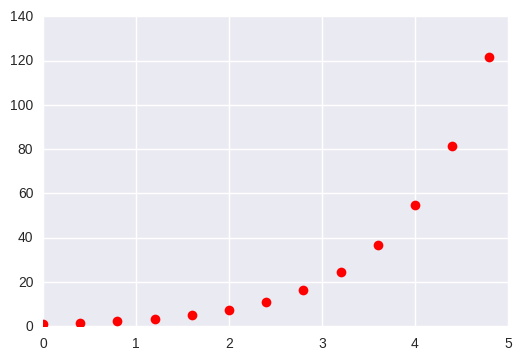

In [21]:
vals = np.arange(0,5,0.4)
vals_exp = np.exp(vals)
plt.plot(vals, vals_exp, 'ro')

### RidgeCV

In [22]:
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

alphas = np.exp(np.arange(0, 5, 0.2))
ridge = RidgeCV(alphas=alphas, scoring='root_mean_squared_error', cv=10)
ridge.fit(train_s_x, train_s_y)

print ridge.score(test_s_x, test_s_y)
print 'MSE on log:', np.sqrt(mean_squared_error(ridge.predict(test_s_x), test_s_y))
print 'alpha:', ridge.alpha_

0.867224534535
MSE on log: 0.140670223261
alpha: 13.463738035


### DEMO: influence of alpha 

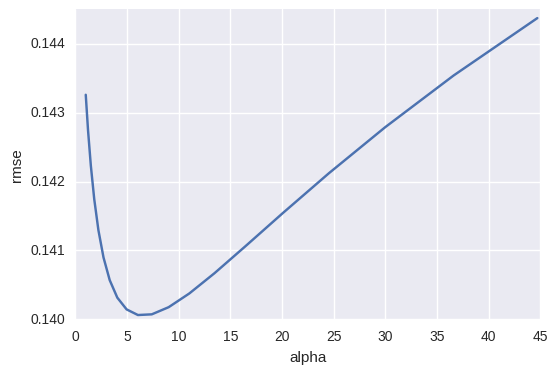

In [23]:
from sklearn.linear_model import Ridge

alphas_trimmed = np.exp(np.arange(0, 4, 0.2))
scores = []

for alpha in alphas_trimmed:
    rdg = Ridge(alpha=alpha).fit(train_s_x, train_s_y)
    score = np.sqrt(mean_squared_error(rdg.predict(test_s_x), test_s_y))
    scores.append(score)
    
plt.plot(alphas_trimmed, scores)
plt.xlabel("alpha")
plt.ylabel("rmse")

### Lasso for feature selection

In [50]:
from sklearn.linear_model import LassoCV

alphas = [1, 0.1, 0.001, 0.0005]
lasso = LassoCV(alphas=alphas, cv=10, max_iter=10000000)
lasso.fit(train_s_x, train_s_y)

print lasso.score(test_s_x, test_s_y)
print 'MSE on log:', np.sqrt(mean_squared_error(lasso.predict(test_s_x), test_s_y))
print 'alpha:', lasso.alpha_

0.862045412299
MSE on log: 0.143387513692
alpha: 0.001


In [51]:
sign_cols = [col for col, coef in zip(list(train_s_x), lasso.coef_) if coef > 0]

In [52]:
print len(list(train_s_x)) - len(sign_cols), 'columns out of', len(list(train_s_x)) , 'dropped'
print len(sign_cols), 'remaining'

237 columns out of 287 dropped
50 remaining


### Ridge

In [27]:
alphas = np.exp(np.arange(0, 5, 0.2))
ridge = RidgeCV(alphas=alphas, scoring='root_mean_squared_error', cv=10)
ridge.fit(train_s_x, train_s_y)

print ridge.score(test_s_x, test_s_y)
print 'MSE on log:', np.sqrt(mean_squared_error(ridge.predict(test_s_x), test_s_y))
print 'alpha:', ridge.alpha_

0.867224534535
MSE on log: 0.140670223261
alpha: 13.463738035


### Random Forest Regressor

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

RFR = RandomForestRegressor(n_estimators=100)

grid_params = {
    'max_depth': [2,4,6,8],
    'min_samples_leaf': [3,5,9,17],
    'max_features': [1.0,0.3,0.1]
}

# grid_search = GridSearchCV(RFR, param_grid=grid_params)
# grid_search.fit(train_s_x[sign_cols], train_s_y)
# print('Best score: {}'.format(grid_search.best_score_))
# print('Best parameters: {}'.format(grid_search.best_params_))

In [29]:
RFR = RandomForestRegressor(n_estimators=200, max_features=0.3, max_depth=8, min_samples_leaf=3)

RFR.fit(train_s_x[sign_cols], train_s_y)
print RFR.score(test_s_x[sign_cols], test_s_y)
print 'MSE on log:', np.sqrt(mean_squared_error(RFR.predict(test_s_x[sign_cols]), test_s_y))

0.863716462406
MSE on log: 0.142516438119


### Gradient Boosting Regressor

In [30]:
from sklearn.ensemble import GradientBoostingRegressor

GBR = GradientBoostingRegressor(n_estimators=100)

grid_params = {
    'learning_rate': [0.5, 0.1, 0.05],
    'max_depth': [2,4,6,8],
    'min_samples_leaf': [3,5,9,17],
    'max_features': [1.0,0.3,0.1]
}

grid_search = GridSearchCV(GBR, param_grid=grid_params)
grid_search.fit(train_s_x[sign_cols], train_s_y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.897672238956
Best parameters: {'max_features': 0.3, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 17}


In [64]:
GBR = GradientBoostingRegressor(n_estimators=200, max_features=0.3, learning_rate=0.1, max_depth=4, min_samples_leaf=17)

GBR.fit(train_s_x[sign_cols], train_s_y)
print GBR.score(test_s_x[sign_cols], test_s_y)
print 'MSE on log:', np.sqrt(mean_squared_error(GBR.predict(test_s_x[sign_cols]), test_s_y))

0.901993202618
MSE on log: 0.120856874677


### Stochastic Gradient Descent Regressor (not aplicable since #samples < 100K)

In [263]:
print 'nr of samples:',  len(train_s_x[sign_cols])

nr of samples: 1100


In [264]:
from sklearn.linear_model import SGDRegressor

SGDR = SGDRegressor()

SGDR.fit(train_s_x[sign_cols], train_s_y)
print SGDR.score(test_s_x[sign_cols], test_s_y)
print 'MSE on log:', np.sqrt(mean_squared_error(SGDR.predict(test_s_x[sign_cols]), test_s_y))

0.694339104512
MSE on log: 0.213433802129


### Support Vector Regressor 

In [39]:
from sklearn.svm import SVR

SVReg = SVR()

param_grid = {'C': [1e0, 1e1, 1e2, 1e3],
              'gamma': np.logspace(-2, 2, 5)}

grid_search = GridSearchCV(SVReg, param_grid=param_grid)
grid_search.fit(train_s_x[sign_cols], train_s_y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.0435167326036
Best parameters: {'C': 10.0, 'gamma': 0.01}


In [40]:
SVReg = SVR(C=10.0, gamma=0.01)

SVReg.fit(train_s_x[sign_cols], train_s_y)
print SVReg.score(test_s_x[sign_cols], test_s_y)
print 'MSE on log:', np.sqrt(mean_squared_error(SVReg.predict(test_s_x[sign_cols]), test_s_y))

0.0611396993293
MSE on log: 0.374062134893


### partial dependence

In [267]:
imp_col = zip(GBR.feature_importances_, list(train_s_x[sign_cols]))
feature_importances = sorted(imp_col, key=lambda x: x[0], reverse=True)
top_features = [tpl[1] for tpl in feature_importances if tpl[0]>0.04]

dependence on combos of 9 features


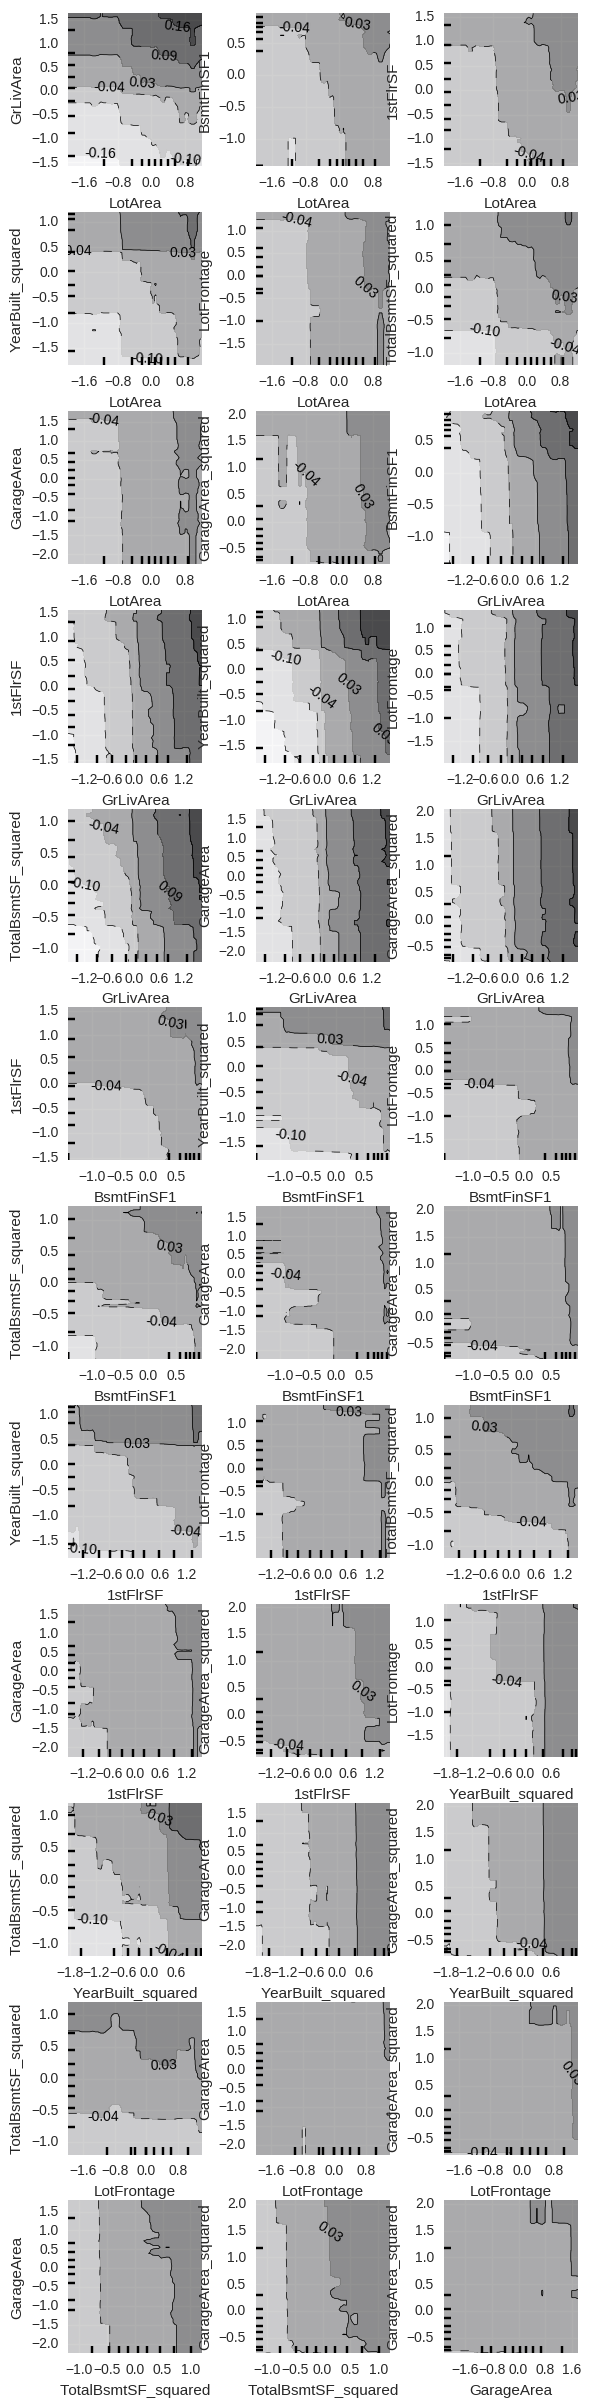

In [268]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from itertools import combinations

top_features_idx = [list(train_s_x[sign_cols]).index(f) for f in top_features]
top_features_combos = list(combinations(top_features_idx, 2))
feature_names = list(train_s_x[sign_cols])

print 'dependence on combos of ' + str(len(top_features_idx)) + ' features'
fig, axs = plot_partial_dependence(GBR, train_s_x[sign_cols], top_features_combos,
                                   feature_names=feature_names, grid_resolution=50)

plt.subplots_adjust(top=6)

### make submission

In [41]:
test_dataset_raw = pd.read_csv("test.csv") 
test_dataset = test_dataset_raw.copy()

In [42]:
#test_dataset = num_to_cat(test_dataset, ['MSSubClass', 'MoSold'])

test_dataset[skewed_col_idx] = np.log1p(test_dataset[skewed_col_idx])

test_dataset = test_dataset.drop('Id', axis=1)
test_dataset = one_hot_encode(test_dataset, one_hot_cols)
test_dataset = test_dataset.fillna(test_dataset.mean())
test_dataset = get_polynomials(test_dataset, large_corr_feats, 2)
test_dataset = get_polynomials(test_dataset, large_corr_feats, 3)

#test_dataset.loc[:, numerical_features] = stdScal.transform(test_dataset.loc[:, numerical_features])

In [43]:
print train_s_x.shape
print test_dataset.shape

(1100, 287)
(1459, 287)


In [44]:
log_predictions = GBR.predict(test_dataset[sign_cols])

In [45]:
print log_predictions[:3]
print dataset['SalePrice'][:3]

[ 11.70291723  11.9862236   12.10192796]
0    208500
1    181500
2    223500
Name: SalePrice, dtype: int64


In [46]:
predictions = np.exp(log_predictions)

In [47]:
print predictions[:3]
print dataset['SalePrice'][:3]

[ 120923.96406161  160527.99046619  180218.98224388]
0    208500
1    181500
2    223500
Name: SalePrice, dtype: int64


In [48]:
submission = pd.DataFrame({
    "Id": test_dataset_raw['Id'],
    "SalePrice": predictions
})

# submission.to_csv("houses_sub_15.csv", index=False)